In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors


from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *

from scipy.optimize import root
from scipy.interpolate import interp1d
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [90]:
grid  = Cylindrical_Grid(200e-6, N=200) 
Z, A = 54, 131
Te_initial, Ti_initial = 20.6e3, 0#16.60952380952381e3, 9.32e3 #[K]
temperature_measurement_width = 20e-6 # [m]
gaussian_FWHM = 105.2e-6
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"


# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Z, A, Te_initial, Ti_initial, gaussian_FWHM, temperature_measurement_width,
                      gas_name='Xenon', model = "SMT", ion_temperature_model = 'MD',
                      ion_temperature_file=dih_file, electron_temperature_model='gaussian', 
                      Te_experiment_is_peak=True, super_gaussian_power=1)

ttm = HydroModel(Xenon_jt, model = "SMT")

# Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT",
#                       ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
# ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Te_max = 2.060e+04 K


In [91]:
%%time
ttm.solve_hydro(tmax=18e-9, dt=1e-10)

CPU times: user 9.99 s, sys: 0 ns, total: 9.99 s
Wall time: 9.99 s


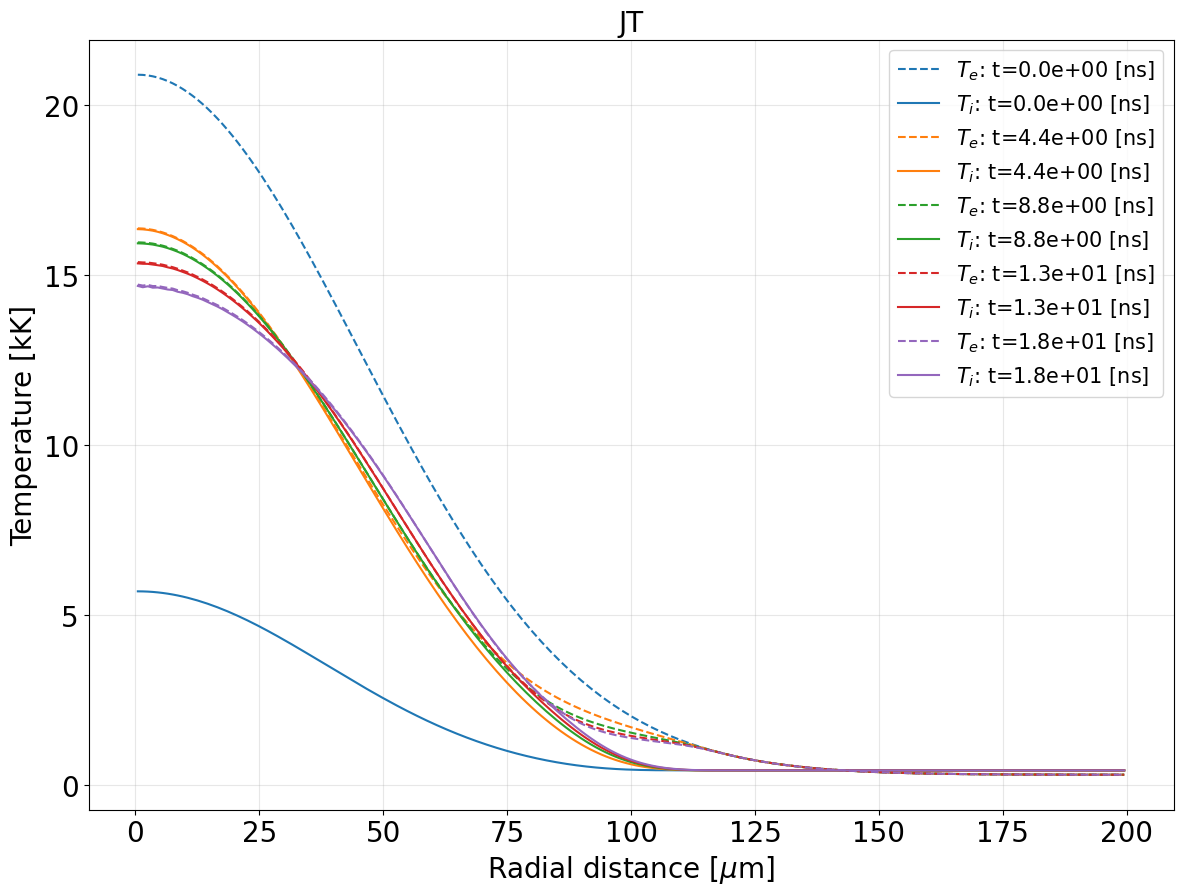

In [92]:
def plot_temp_profiles(ttm, plot_times = None, ax = None, title='', normalized=False):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_saved_list)*0.99,num=5,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    
        
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_saved_list[ti]
        if normalized==True:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]/ttm.Te_list[ti][0], '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]/ttm.Ti_list[ti][0], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        else:
            ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, ttm.Zbar_list[ti][:-1], '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.n__list[ti][:-1])/(ttm.n_i_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Te_list[ti][1:])-(ttm.Te_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
#             ax.plot(grid.cell_centers*1e6, (ttm.Ti_list[ti][1:])-(ttm.Ti_list[ti][:-1]), '.', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
            
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.set_xlim(55,85)
#     ax.set_ylim(0,3)
#     ax.set_yscale('log')
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)

    
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
plot_temp_profiles(ttm, ax = ax[0], title='JT', normalized=False, plot_times=None)#[12,13,14])


# Get Intensity From Absorption Integral over Line of Sight

In [93]:
class Measurements():
    
    def __init__(self, Z, A, r_array, n_e_array, n_i_array, Te_array, Ti_array, R_max = 100e-6, Nx = 100, Nz=500):
        self.Z, self.A = Z, A
        self.r_array  = r_array
        self.n_e_array = n_e_array
        self.n_i_array = n_i_array
        self.Te_array  = Te_array
        self.Ti_array  = Ti_array
        self.Zbar_array= self.n_e_array/self.n_i_array
        
        self.m_i = A*m_p
        
        self.x, self.z = np.linspace(-R_max,R_max, num=Nx), np.linspace(-R_max,R_max, num=Nz)
        self.dx, self.dz = self.x[1]-self.x[0], self.z[1]-self.z[0]
        self.X, self.Z = np.meshgrid(self.x,self.z, indexing='ij')
        self.ρ_grid = np.sqrt(self.X**2 + self.Z**2)
        
        self.make_parameter_grids()
        self.make_eff_parameters()
        self.make_spectral_parameters()
        self.fit_Te_with_spectral_Intensity()

    def convert_r_array_to_grid(self, array, fill_value='extrapolate'):
        array_func = interp1d(self.r_array, array, bounds_error=False, fill_value=fill_value)
        grid = array_func(self.ρ_grid)
        return grid

    def make_parameter_grids(self):
        self.n_e_grid = self.convert_r_array_to_grid(self.n_e_array)
        self.n_i_grid = self.convert_r_array_to_grid(self.n_i_array)
        self.Te_grid  = self.convert_r_array_to_grid(self.Te_array)
        self.Ti_grid  = self.convert_r_array_to_grid(self.Ti_array)
        self.Zbar_grid= self.convert_r_array_to_grid(self.Zbar_array)
        
    def make_εeff_grid(self):
        self.ε_grid = np.zeros_like(self.κeff_grid)
        for x_i in range(self.κeff_grid.shape[0]):
            for z_i in range(self.κeff_grid.shape[1]):
                self.ε_grid[x_i, z_i] = np.exp(-np.sum(self.dz*self.κeff_grid[x_i,:z_i]))
        return self.ε_grid

    def make_ε_grid(self):
        self.ε_grid = np.zeros((len(self.x), len(self.z), len(self.ωs)))
        for x_i in range(len(self.x)):
            for z_i in range(len(self.z)):
                self.ε_grid[x_i, z_i, :] = np.exp(-np.sum(self.κ_grid[x_i,:z_i,:]*self.dz,axis=0))
        return self.ε_grid

    def make_eff_parameters(self):
        self.κeff_grid = np.nan_to_num(JT_GMS.effective_photon_absorption_coefficient(self.m_i, self.n_i_grid, 
                                                                                       self.n_e_grid, self.Ti_grid, 
                                                                                       self.Te_grid, self.Zbar_grid), nan=1e8)
        self.εeff_grid = self.make_εeff_grid() 
        self.Ieff_grid = self.Te_grid**4*self.εeff_grid
        self.Ieff_unnormalized = np.array([np.sum(self.dz*self.Te_grid[x_i]**4*self.εeff_grid[x_i])/1e16 for x_i in range(len(self.x))])

    def make_spectral_parameters(self):
        self.ωs = k_B/hbar*np.geomspace(np.min(self.Te_grid*10), np.max(self.Te_grid*100),num=200 )
        self.dω = self.ωs[1:]-self.ωs[:-1]
        self.λs = 2*π*c/self.ωs[::-1]
        self.dλ = self.λs[1:]-self.λs[:-1]

        self.κ_grid = JT_GMS.photon_absorption_coefficient(self.ωs[np.newaxis,np.newaxis,:], self.m_i,
                                                            self.n_i_grid[:,:,np.newaxis], 
                                                            self.n_e_grid[:,:,np.newaxis], 
                                                            self.Ti_grid[:,:,np.newaxis], 
                                                            self.Te_grid[:,:,np.newaxis], 
                                                            self.Zbar_grid[:,:,np.newaxis])
        self.κ_grid = np.nan_to_num(self.κ_grid, nan=1e10)

        self.Bω_grid = JT_GMS.photon_angular_frequency_density(self.ωs[np.newaxis,np.newaxis,:],self.Te_grid[:,:,np.newaxis])
        self.Bλ_grid = JT_GMS.photon_wavelength_density(self.λs[np.newaxis,np.newaxis,:],self.Te_grid[:,:,np.newaxis])

        self.ε_grid = self.make_ε_grid() 
        self.Iω_grid = self.Bω_grid * self.ε_grid
        self.Iλ_grid = self.Bλ_grid * self.ε_grid
        # ω
        self.Iω_unnormalized_of_r = np.array([np.sum(self.Iω_grid[x_i], axis=0) for x_i in range(len(self.x))])
        self.Iω_unnormalized = np.sum(self.Iω_unnormalized_of_r*self.dx, axis=0)
        self.I_unnormalized_of_r = np.sum(self.Iω_unnormalized_of_r[:,1:]*self.dω[np.newaxis,:], axis=1)
        # λ
        self.Iλ_unnormalized_of_r = np.array([np.sum(self.Iλ_grid[x_i], axis=0) for x_i in range(len(self.x))])
        self.Iλ_unnormalized = np.sum(self.Iλ_unnormalized_of_r*self.dx, axis=0)
        
        FWHM_index = np.argmin(np.abs(self.I_unnormalized_of_r-np.max(self.I_unnormalized_of_r)/2 )) 
        self.FWHM = np.abs(2*self.x[FWHM_index])

    def plot_parameter(self, parameter_grid, label=''):
        plt.figure(figsize=(10, 7))
        contour = plt.contourf(self.X*1e6, self.Z*1e6, parameter_grid, levels=100, cmap='viridis')

        cbar = plt.colorbar(contour)
        cbar.set_label(label, size=20)
        cbar.ax.tick_params(labelsize=20)

        plt.xlabel('x [μm]', fontsize=20)
        plt.ylabel('z [μm]', fontsize=20)

        plt.tick_params(labelsize=20)

        plt.show()
        
    def plot_emissivity_and_intensity(self,Intensity_grid):
        # Gridspec is now 2x2 with sharp width ratios
        gs = gridspec.GridSpec(2,2,height_ratios=[4,1],width_ratios=[20,1])
        fig = plt.figure(figsize=(8,6))

        # Contour plot axis
        cax = fig.add_subplot(gs[0])

        # Create the contour plot
        contour = cax.contourf(self.X*1e6, self.Z*1e6, self.εeff_grid, levels=100, cmap='viridis')
        cax.set_ylabel('z (μm)', fontsize=20)
        cax.tick_params(labelsize=20)

        # Intensity plot axis
        lax = fig.add_subplot(gs[2], sharex=cax)

        # Create the Intensity plot
        lax.plot(self.X[:,0]*1e6, Intensity_grid/np.max(Intensity_grid), color='b')
        lax.set_xlabel('x (μm)', fontsize=20)
        lax.set_ylabel('Intensity', fontsize=20)
        lax.tick_params(labelsize=20)
        lax.set_ylim(0,1)

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        
        textstr = "FWHM = {0:.1f} μm".format(self.FWHM*1e6)
        lax.text(0.03, 0.93, textstr, transform=lax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

        # Make a subplot for the colour bar
        bax = fig.add_subplot(gs[1])

        # Use general colour bar with specific axis given.
        cbar = plt.colorbar(contour, cax=bax)
        cbar.set_label('Emissivity Estimate', size=20)
        cbar.ax.tick_params(labelsize=20)

        plt.tight_layout()
        plt.show()
        
    def fit_Te_with_spectral_Intensity(self):
        test_Boltzmann = lambda Te: JT_GMS.photon_wavelength_density(self.λs, Te)
        f_to_min = lambda Te: np.linalg.norm( self.Iλ_unnormalized/np.max(self.Iλ_unnormalized) - test_Boltzmann(Te)/np.max(test_Boltzmann(Te)) )
        sol = root(f_to_min, 1e4)
        self.Te_fit = float(sol.x)
        self.spectral_intensity_fit = test_Boltzmann(self.Te_fit)

    def plot_spectral_Intensity(self):
        self.fit_Te_with_spectral_Intensity()

        plt.figure(figsize=(10, 7))
        plt.plot(self.λs*1e9, self.Iλ_unnormalized/np.max(self.Iλ_unnormalized), label="Integrated over profile")
        plt.plot(self.λs*1e9, self.spectral_intensity_fit/np.max(self.spectral_intensity_fit), label="Te={0:.1f} kK".format(self.Te_fit[0]*1e-3))

        plt.xlabel('λ [nm]', fontsize=20)
        plt.ylabel('Normalized Intensity', fontsize=20)

        plt.legend(fontsize=20)
        plt.tick_params(labelsize=20)

        plt.show()

In [94]:
exp_measurement = Measurements(Z, A, ttm.grid.r, ttm.n_e, ttm.n_i, ttm.Te, ttm.Ti, R_max = 100e-6, Nx = 500, Nz=100)
print("Initial T_e = {0:.1f} [kK], FWHM = {1:.1f} [µm]".format(float(exp_measurement.Te_fit)/1e3, exp_measurement.FWHM*1e6))

/home/zach/plasma/TTM/physics.py:300: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ
/home/zach/plasma/TTM/physics.py:363: RuntimeWarning: overflow encountered in exp
  B_ω = hbar * ω**3/(4*π**3*c**2)* 1/(np.exp(hbar*ω/(k_B*Te))-1)
/home/zach/plasma/TTM/physics.py:350: RuntimeWarning: overflow encountered in exp
  B_λ = 4*π*hbar * c**2/λ**5 * 1/(np.exp(2*π*hbar*c/(λ*k_B*Te))-1)


Initial T_e = 12.2 [kK], FWHM = 58.9 [µm]


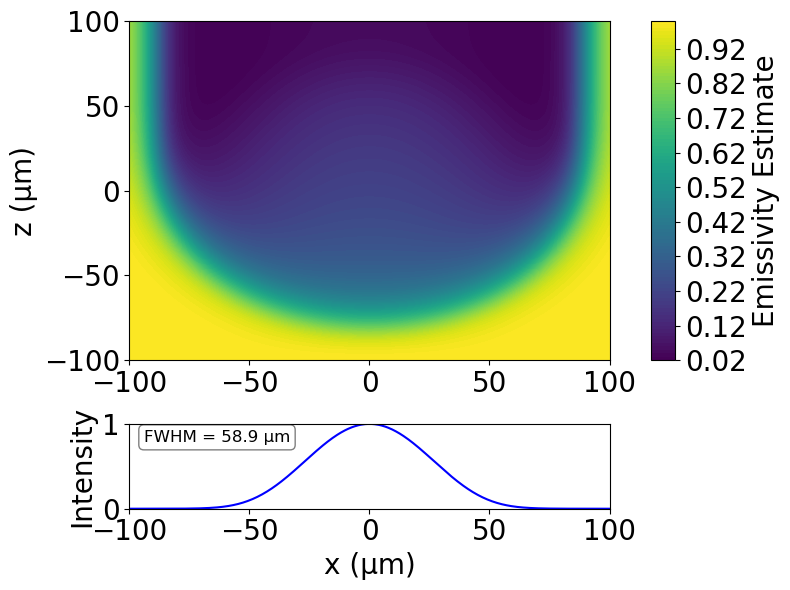

In [95]:
exp_measurement.plot_emissivity_and_intensity(exp_measurement.I_unnormalized_of_r)#fit_Te_with_spectral_Intensity()

In [96]:
%%time
i=0
exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 5000, Nz=100)
print("t:{0:.2f} [ns], T_e = {1:.2f} [kK], FWHM = {2:.2f} [µm]".format(ttm.t_saved_list[i]*1e9, float(exp_i.Te_fit)/1e3, exp_i.FWHM*1e6))

t:0.00 [ns], T_e = 16.62 [kK], FWHM = 51.17 [µm]
CPU times: user 13.7 s, sys: 2.9 s, total: 16.6 s
Wall time: 16.6 s


In [97]:
%%time
i=1
exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 5000, Nz=100)
print("t:{0:.2f} [ns], T_e = {1:.2f} [kK], FWHM = {2:.2f} [µm]".format(ttm.t_saved_list[i]*1e9, float(exp_i.Te_fit)/1e3, exp_i.FWHM*1e6))

t:0.10 [ns], T_e = 16.06 [kK], FWHM = 51.33 [µm]
CPU times: user 13 s, sys: 2.69 s, total: 15.7 s
Wall time: 15.7 s


In [98]:
%%time
FWHM_list = []
FWHM_t_list = ttm.t_saved_list#[:1400][::100]
Te_fit_list = []

for i, ti in enumerate(ttm.t_saved_list):#[:1400][::100]):
    exp_i = Measurements(Z, A, ttm.grid.r, ttm.n_e_list[i], ttm.n_i_list[i], ttm.Te_list[i], ttm.Ti_list[i], R_max = 100e-6, Nx = 5000, Nz=100)
    FWHM_list.append(exp_i.FWHM)
    Te_fit_list.append(exp_i.Te_fit)

KeyboardInterrupt: 

In [101]:
len(FWHM_list)
len()

66

# Comparison to Experiment

In [99]:
Xe_data = read_csv("./data/experimental_data/Xe_5bar_Te.txt", delim_whitespace=True, header=1)
Xe_FWHM_data = read_csv("./data/experimental_data/Xe_5bar_FWHM.txt", delim_whitespace=True, header=1)

ValueError: x and y must have same first dimension, but have shapes (179,) and (66,)

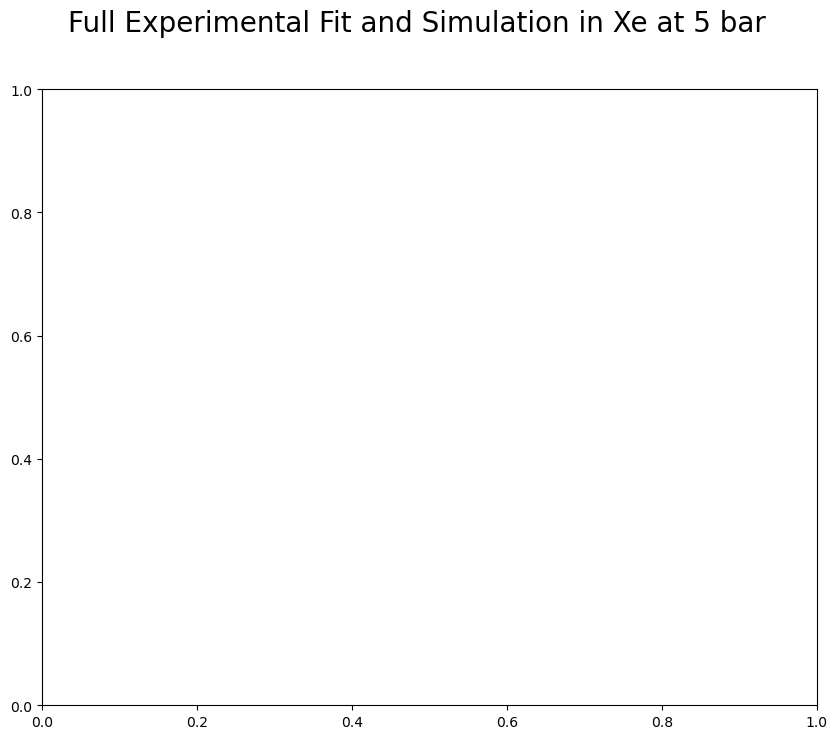

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Full Experimental Fit and Simulation in Xe at 5 bar", fontsize=20)

ax.plot(np.array(FWHM_t_list)*1e9, np.array(Te_fit_list)/1e3,'--', color='r', )
ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r.', label='Experiment Data')

ax.set_ylabel(r'$T_e$ [kK]', fontsize=20, color='r')
ax.set_xlabel('t [ns]', fontsize=20)
# ax.set_xlim(0,12)

# ax.set_ylim(40,60)
ax.tick_params(labelsize=20)
ax.tick_params(axis='y',color='r', labelcolor='r')

ax2 = ax.twinx()
ax2.plot(np.array(FWHM_t_list)*1e9, np.array(FWHM_list)*1e6,'--.k')
ax2.plot(Xe_FWHM_data['t[ns]'], Xe_FWHM_data['FWHM[μm]'], 'k.', label='Experiment Data')

ax2.set_ylabel('FWHM [$\mu$m]', fontsize=20)
ax2.tick_params(labelsize=20)

In [ ]:
from scipy.optimize import curve_fit

def T_fit_form(t, Te_0, Ti_0, d, τei):
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

def T_DIHfit_form(t, Te_0, d, τei):
    Ti_0 = Ti_initial
    ΔT0 = (Te_0-Ti_0)
    ΣT0 = (Te_0+Ti_0)
    return ΣT0/2 - d*t + ΔT0/2*np.exp(-2*t/τei)

Te0_fit, Ti0_fit, d_fit, τei_fit = curve_fit(T_fit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit = curve_fit(T_DIHfit_form, Xe_data['t[ns]'], Xe_data['T[kK]'] )[0]
Te0_DIHfit, d_DIHfit, τei_DIHfit

In [ ]:
def plot_bulk_temperature(ttm,ax, plot_times = None, title=''):
    bulk_Tes = np.array(Te_fit_list)

    ti_1, ti_2 = -100, -1

    dT_dt  = (bulk_Tes[ti_2] - bulk_Tes[ti_1])/(FWHM_t_list[ti_2] - FWHM_t_list[ti_1])

#     T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


    ax.plot(np.array(ttm.t_saved_list)*1e9, bulk_Tes*1e-3,label=r"$T_e$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, bulk_Tis*1e-3,label=r"$T_i$ (bulk)")
#     ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k',label='Linear Diffusion line')
#     ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))
    
#     bulk_T_exp_fit = (Te_initial + Ti_initial)/2 - 0.5*120*1e9*ttm.t_list + (Te_initial - Ti_initial)/2 * np.exp(-ttm.t_list/(1470e-12))
#     print(bulk_T_exp_fit)
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_fit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, Ti0_fit, d_fit, τei_fit),'r--' ,label="Experiment Fit")
#     ax.plot(np.array(ttm.t_saved_list)*1e9, T_DIHfit_form(np.array(ttm.t_saved_list)*1e9, Te0_fit, d_fit, τei_fit),'r-.' ,label="Experiment DIH fixed Fit")
    ax.plot(Xe_data['t[ns]'], Xe_data['T[kK]'], 'r-', label='Experiment Data')
    # Thermalization Text
    thermalization_text = r'$\tau_{th}$' + ' = {0:.1f} [ps] (exp 1470 ps)'.format(ttm.experiment.τei_Equilibration*1e12)
    thermalization_head_x_pos = 0.5* ttm.experiment.τei_Equilibration*1e9
    thermalization_head_y_pos = bulk_Tes[np.argmin(np.abs(ttm.t_list-thermalization_head_x_pos*1e-9))]*1e-3
    
    thermalization_arrow_head_coords = (thermalization_head_x_pos, thermalization_head_y_pos )
    ax.annotate(thermalization_text, xy=thermalization_arrow_head_coords, xycoords='data',
                xytext=(150, 60), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))

    # Diffusion Text
    diffusion_text = 'Diffusion Estimate:\n dT/dt={0:.2f} [K/ns] (exp -120 K/ns)'.format(dT_dt*1e-9)
    diffusion_head_x_pos = 0.5*ttm.tmax*1e9
    diffusion_head_y_pos = 0.1 + bulk_Tes[np.argmin(np.abs(ttm.t_list-diffusion_head_x_pos*1e-9))]*1e-3
    
    diffusion_arrow_head_coords = (diffusion_head_x_pos, diffusion_head_y_pos )
    ax.annotate(diffusion_text, xy=diffusion_arrow_head_coords, xycoords='data',
                xytext=(60, 30), textcoords='offset points',
                va='top', ha='left',fontsize=15,
                arrowprops=dict(facecolor='black', shrink=0.02))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    fit_string =  (r"My fit: $τ_{{ei}}$ = {0:.1f} [ps]".format(τei_fit*1e3) + '\n'+
                   r" $dT_e/dt$ = -{0:.1f} K/ns".format(d_fit*1e3) + '\n' +
                   r" $T^{{\rm init}}_e$ = {0:.2f} [kK]".format(Te0_fit) + '\n' +
                   r" $T^{{\rm init}}_i$ = {0:.2f} [kK]".format(Ti0_fit)

                  )
    ax.text(0.5, 0.95, fit_string, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    # Plot settings
    ax.set_xlabel(r"Time [ns]", fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(-0.1,ttm.tmax*1e9)
    ax.set_ylim(10,17)

    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(alpha=0.3)


TypeError: unsupported format string passed to numpy.ndarray.__format__

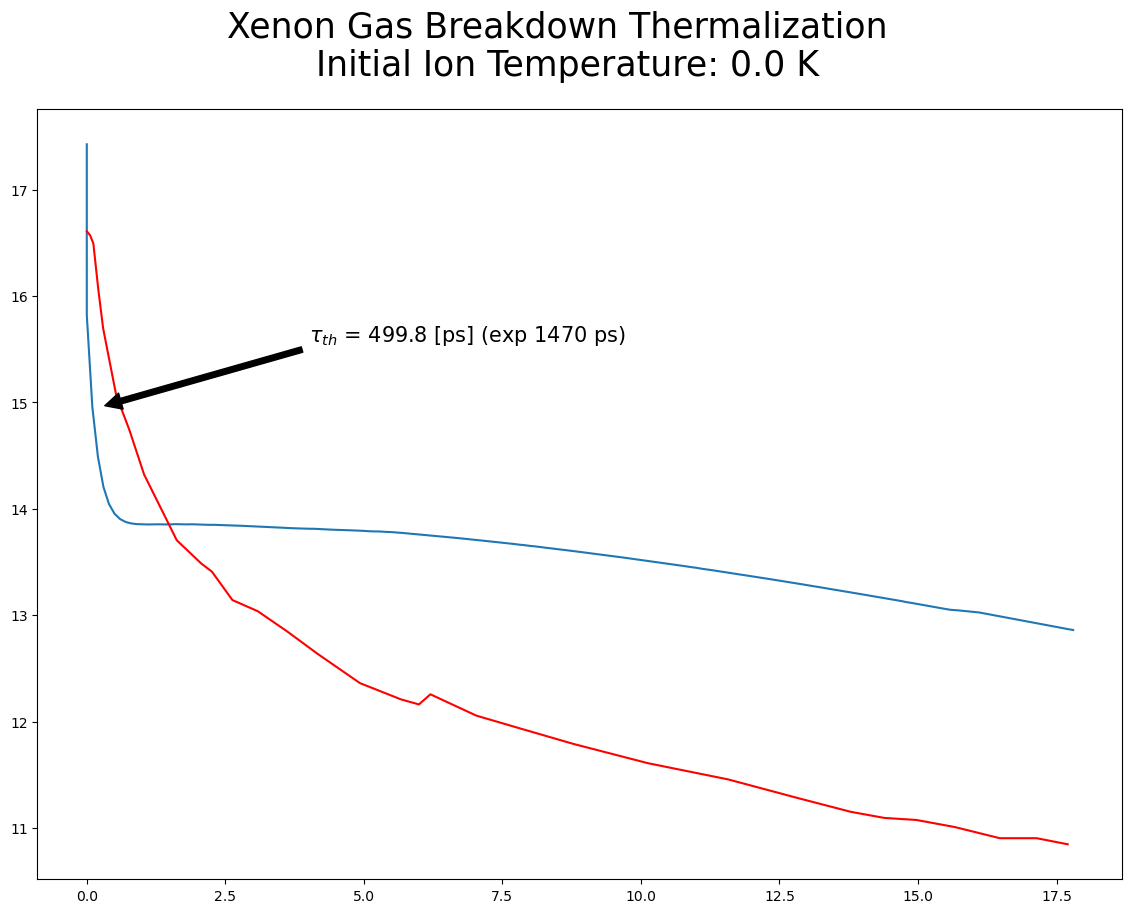

In [19]:
fig, ax = plt.subplots(1,1, figsize=(14,10),facecolor='w')
ax = np.array([ax])
fig.suptitle('Xenon Gas Breakdown Thermalization \n Initial Ion Temperature: {0:.1f} K'.format(Ti_initial),fontsize=25)

plot_bulk_temperature(ttm, ax[0], title='JT GMS')
fig.tight_layout()